## A) Import libs 

In [1]:
#import libs
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import math

# import files 
from DataSet import DataSet
from DataGen import DataGen  
from DataGen import DataGen
from utilities import map_plot

## B) Load matlab data with DataSet class

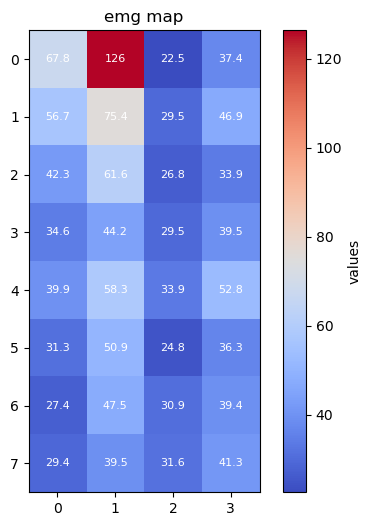

In [2]:
# Load dataset and extract relevant data
ds = DataSet('../data/', 'rat', 'rat1_M1_190716.mat', 'rat1')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

emg = 4

# Extract relevant variables from the dataset
ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

# Initialize an empty map for EMG values, with shape based on the maximum x and y positions
map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

# Loop over each channel and assign its response mean value to the corresponding position in the EMG map
for i in range(ch2xy.shape[0]):
    # Convert the (x, y) position to zero-based indices and set the EMG value at that position
    map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

# Plot the generated EMG map using the previously defined map_plot function
map_plot(map_emg, 'emg map')

## TEST

In [3]:
name = 'TTTTTTTTTTTTTTTTTTEST_5que_100comb_rat6_emg4'

In [4]:
dg = DataGen(map_emg)
dg.generate_pre_labeled_inputs(name=name, nb_queries=5, nb_comb=10, 
                               kernel_type='Mat52', noise_std=0.1, 
                               output_std=3, lengthscale=[1.*1/7, 1.*1/3],
                               combination=False, combination_without_rep=False
                               )
dg.format_labeled_inputs(name=name)

These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: C_TTTTTTTTTTTTTTTTTTEST_5que_100comb_rat6_emg4
 nb_queries: 5
 nb_comb: 10
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


## C) Generate data for the NN with DataGen class

In [ ]:
name = '10que_10kcomb_rat6_emg4'

In [ ]:
dg = DataGen(map_emg)
dg.generate_pre_labeled_inputs(name=name, nb_queries=5, nb_comb=10000, 
                               kernel_type='Mat52', noise_std=0.1, 
                               output_std=3, lengthscale=[1.*1/7, 1.*1/3])
dg.format_labeled_inputs(name=name)

These pre-labeled inputs were made with these parameters:
 name: A_10que_10kcomb_rat6_emg4
 nb_queries: 10
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


## D) Generate data for the NN with DataGen class for all the EMGs of 1 rat

In [ ]:
# Load dataset and extract relevant data
ds = DataSet('../data/', 'rat', 'rat5_M1_191112.mat', 'rat5')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

for emg in range(len(ds.set['emgs'])):

    # Extract relevant variables from the dataset
    ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
    sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
    output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

    # Initialize an empty map for EMG values, with shape based on the maximum x and y positions
    map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

    # Loop over each channel and assign its response mean value to the corresponding position in the EMG map
    for i in range(ch2xy.shape[0]):
        # Convert the (x, y) position to zero-based indices and set the EMG value at that position
        map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

    name = f'10que_10kcomb_{ds.dataset_name}_emg{emg+1}'

    dg = DataGen(map_emg)
    dg.generate_pre_labeled_inputs(name=name, nb_queries=10, nb_comb=10000, 
                                kernel_type='Mat52', noise_std=0.1, 
                                output_std=3, lengthscale=[1.*1/7, 1.*1/3], using_GPytorch=True)
    dg.format_labeled_inputs(name=name)


These pre-labeled inputs were made with these parameters:
 name: A_10que_10kcomb_rat5_emg1
 nb_queries: 10
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_10que_10kcomb_rat5_emg2
 nb_queries: 10
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_10que_10kcomb_rat5_emg3
 nb_queries: 10
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_10que_10kcomb_rat5_emg4
 nb_queries: 10
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_10que_10kcomb

In [4]:
# Load dataset and extract relevant data
ds = DataSet('../data/', 'rat', 'rat1_M1_190716.mat', 'rat1')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

for emg in range(len(ds.set['emgs'])):

    # Extract relevant variables from the dataset
    ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
    sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
    output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

    # Initialize an empty map for EMG values, with shape based on the maximum x and y positions
    map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

    # Loop over each channel and assign its response mean value to the corresponding position in the EMG map
    for i in range(ch2xy.shape[0]):
        # Convert the (x, y) position to zero-based indices and set the EMG value at that position
        map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

    name = f'TESTTTTT2to20que_{ds.dataset_name}_emg{emg+1}'
    nb_queries = list(range(2,21))
    # nb_comb = [min(math.comb(32, i) // 4, 1000) for i in nb_queries]
    nb_comb = [min(math.comb(32, i) // 4, 10) for i in nb_queries]


    dg = DataGen(map_emg)
    dg.generate_pre_labeled_inputs(name=name, nb_queries=nb_queries, nb_comb=nb_comb, 
                                kernel_type='Matern52', noise=0.1, 
                                outputscale=3, lengthscale=[1.*1/7, 1.*1/3], using_GPytorch=True)
    dg.format_labeled_inputs(name=name)

These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: C4_TESTTTTT2to20que_rat1_emg1
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
 kernel_type: Matern52
 noise: 0.1
 outputscale: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: C4_TESTTTTT2to20que_rat1_emg2
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
 kernel_type: Matern52
 noise: 0.1
 outputscale: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These 

In [5]:
# Load dataset and extract relevant data
ds = DataSet('../data/', 'rat', 'rat1_M1_190716.mat', 'rat1')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

for emg in range(len(ds.set['emgs'])):

    # Extract relevant variables from the dataset
    ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
    sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
    output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

    # Initialize an empty map for EMG values, with shape based on the maximum x and y positions
    map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

    # Loop over each channel and assign its response mean value to the corresponding position in the EMG map
    for i in range(ch2xy.shape[0]):
        # Convert the (x, y) position to zero-based indices and set the EMG value at that position
        map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

    name = f'TESTTTTT2to20que_{ds.dataset_name}_emg{emg+1}'
    nb_queries = list(range(2,21))
    # nb_comb = [min(math.comb(32, i) // 4, 1000) for i in nb_queries]
    nb_comb = [min(math.comb(32, i) // 4, 10) for i in nb_queries]


    dg = DataGen(map_emg)
    dg.generate_pre_labeled_inputs(name=name, nb_queries=nb_queries, nb_comb=nb_comb, 
                                kernel_type='Matern52', noise=0.1, 
                                outputscale=3, lengthscale=[1.*1/7, 1.*1/3], using_GPytorch=False)
    dg.format_labeled_inputs(name=name)

These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: C3_TESTTTTT2to20que_rat1_emg1
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
 kernel_type: Matern52
 noise: 0.1
 outputscale: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: C3_TESTTTTT2to20que_rat1_emg2
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
 kernel_type: Matern52
 noise: 0.1
 outputscale: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These 

In [ ]:
# Load dataset and extract relevant data
ds = DataSet('../data/', 'rat', 'rat6_M1_200218.mat', 'rat6')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

for emg in range(len(ds.set['emgs'])):

    # Extract relevant variables from the dataset
    ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
    sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
    output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

    # Initialize an empty map for EMG values, with shape based on the maximum x and y positions
    map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

    # Loop over each channel and assign its response mean value to the corresponding position in the EMG map
    for i in range(ch2xy.shape[0]):
        # Convert the (x, y) position to zero-based indices and set the EMG value at that position
        map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

    name = f'2to20que_{ds.dataset_name}_emg{emg+1}'
    nb_queries = list(range(2,21))
    nb_comb = [min(math.comb(32, i) // 4, 1000) for i in nb_queries]


    dg = DataGen(map_emg)
    dg.generate_pre_labeled_inputs(name=name, nb_queries=nb_queries, nb_comb=nb_comb, 
                                kernel_type='Matern52', noise=0.1, 
                                outputscale=3, lengthscale=[1.*1/7, 1.*1/3], using_GPytorch=True)
    dg.format_labeled_inputs(name=name)

## E) Group all the EMGs file for 1 rat in a single file

In [2]:
def concatenate_and_save(input_files, output_file):
    """
    Concatenates data from multiple files and saves it into a single file.

    Args:
        input_files (list of str): List of paths to the input files to load.
        output_file (str): Path to the output file where concatenated data will be saved.
    """
    # Initialize lists to store concatenated data
    all_train_input = []
    all_train_label = []
    all_descriptions = []

    # Load and concatenate data
    for file in input_files:
        loaded_data = torch.load(file, weights_only=True)  # Load data from file
        all_train_input.append(loaded_data["train_input"])  # Append train inputs
        all_train_label.append(loaded_data["train_label"])  # Append train labels
        all_descriptions.append(loaded_data["description"])  # Append descriptions

    # Concatenate tensors and descriptions
    concatenated_train_input = torch.cat(all_train_input, dim=0)  # Concatenate train inputs
    concatenated_train_label = torch.cat(all_train_label, dim=0)  # Concatenate train labels
    concatenated_description = "; ".join(all_descriptions)  # Combine descriptions

    # Save concatenated data into a single file
    output_data = {
        "train_input": concatenated_train_input,
        "train_label": concatenated_train_label,
        "description": concatenated_description,
    }
    torch.save(output_data, output_file)

    print(f"Data has been saved to {output_file}")

In [ ]:
num_rat = 6
nb_k_comb = 10
nb_queries = 20
LETTER = 'C'

input_files = [
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg1.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg2.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg3.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg4.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg5.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg6.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg7.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emg8.pth",
]
output_file = "dataset/emgALL/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emgALL.pth"
concatenate_and_save(input_files, output_file)


In [ ]:
num_rat = 6
nb_k_comb = 'multi'
nb_queries = '2to20'
LETTER = 'C4'

input_files = [
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg1.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg2.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg3.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg4.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg5.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg6.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg7.pth",
    "dataset/single_map/og_"+LETTER+f"_{nb_queries}que_rat{num_rat}_emg8.pth",
]
output_file = "dataset/emgALL/og_"+LETTER+f"_{nb_queries}que_{nb_k_comb}kcomb_rat{num_rat}_emgALL.pth"
concatenate_and_save(input_files, output_file)